In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

COUNTER = 0
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

# Circuito

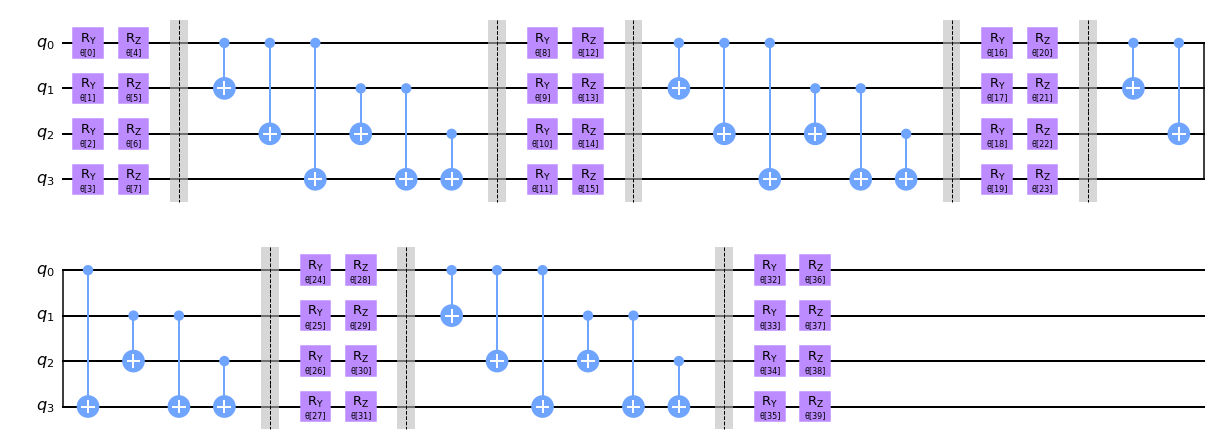

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()
ansatz.decompose().draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [8]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [9]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        #print(exp_val)
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)*(y-y_hat)

In [10]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.3333333333333333
Cost 2.533333333333333
Cost 1.6666666666666667
Cost 2.2
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.8666666666666667
Cost 2.2666666666666666
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.0666666666666667
Cost 1.9333333333333333
Cost 1.7333333333333334
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.2
Cost 1.8
Cost 2.0
Cost 1.8
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.9333333333333333
Cost 1.4666666666666666
Cost 1.9333333333333333
Cost 1.7333333333333334
Cost 2.0
Cost 1.8666666666666667
Cost 2.0
Cost 1.7333333333333334
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 1.6666666666666667
Cost 1.0666666666666667
Cost 2.0
Cost 1.9333333333333333
Cost 2.0
Cost 1.8
Cost 2.0
Cost 2.0
Cost 2.466666666666667
Cost 1.2
Cost 2.0
Cost 2.7333333333333334
Cost 2.0
Cost 2.8666666666666667
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.066666666666667
Cost 2.0
Cost 2.0
Cost 1.2666666666666666
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.1333333333333333
Cost 2.0
Cost 2.066666666666667
Cost 2.0
Cost 2.0
Cost 

Cost 1.2
Cost 1.6
Cost 1.2
Cost 1.0666666666666667
Cost 0.8666666666666667
Cost 1.3333333333333333
Cost 0.8666666666666667
Cost 0.5333333333333333
Cost 1.4666666666666666
Cost 0.6666666666666666
Cost 0.8
Cost 2.0
Cost 1.1333333333333333
Cost 1.0666666666666667
Cost 1.6
Cost 1.1333333333333333
Cost 1.7333333333333334
Cost 1.0
Cost 1.0666666666666667
Cost 1.1333333333333333
Cost 0.8
Cost 0.8666666666666667
Cost 0.8
Cost 1.0
Cost 0.7333333333333333
Cost 1.2
Cost 1.8
Cost 1.0666666666666667
Cost 1.2
Cost 1.4666666666666666
Cost 1.1333333333333333
Cost 0.7333333333333333
Cost 1.3333333333333333
Cost 1.0
Cost 1.0666666666666667
Cost 0.8
Cost 0.5333333333333333
Cost 0.9333333333333333
Cost 2.0
Cost 1.0666666666666667
Cost 1.1333333333333333
Cost 1.0
Cost 1.0
Cost 1.2
Cost 1.2
Cost 1.0666666666666667
Cost 1.0666666666666667
Cost 1.4
Cost 0.9333333333333333
Cost 0.8666666666666667
Cost 1.0
Cost 0.9333333333333333
Cost 1.3333333333333333
Cost 2.0
Cost 1.3333333333333333
Cost 1.4666666666666666
C

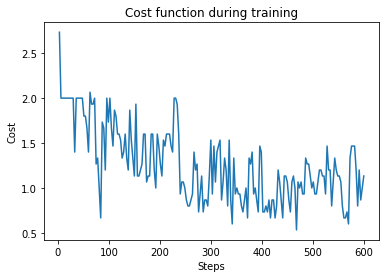

In [11]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [12]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [22]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[ 1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.]
[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1]
Test set accuracy - 0.8888888888888888


## Cross Entropy Loss

### Parity method

In [14]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [15]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [16]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [17]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.6963335265093156
Cost: 0.7435632107224548
Cost: 0.7441451021003069
Cost: 0.7948922836773369
Cost: 0.7440078116934249
Cost: 0.712765358551738
Cost: 0.6965916413983756
Cost: 0.7211598541174383
Cost: 0.736174180712053
Cost: 0.7113523607343382
Cost: 0.749873106664839
Cost: 0.7268094229129578
Cost: 0.7013503542475904
Cost: 0.7510590861843816
Cost: 0.7497122576436133
Cost: 0.6648573294185314
Cost: 0.7507826454512955
Cost: 0.7015434305131217
Cost: 0.7995557634245138
Cost: 0.6947708378237344
Cost: 0.6694187453419802
Cost: 0.7169737729110988
Cost: 0.6960285757977935
Cost: 0.7150480706958574
Cost: 0.7026737945323412
Cost: 0.6605832804613371
Cost: 0.720246695182088
Cost: 0.7064829608193751
Cost: 0.7688921903076904
Cost: 0.7314694620518942
Cost: 0.7355423164361569
Cost: 0.686028773986087
Cost: 0.7095386860828996
Cost: 0.719736583152261
Cost: 0.723663571537887
Cost: 0.7251566944242751
Cost: 0.7380234930366355
Cost: 0.7052568046543111
Cost: 0.7294462817971504
Cost: 0.6924441856979734
Cost: 0

Cost: 0.5799532077505505
Cost: 0.5674124488819179
Cost: 0.5897860831820018
Cost: 0.5805582608312816
Cost: 0.5561307138251582
Cost: 0.5769301456561758
Cost: 0.5964407933800931
Cost: 0.568128306343483
Cost: 0.5746203550235042
Cost: 0.6012577816134094
Cost: 0.5597330069202008
Cost: 0.5803250453551491
Cost: 0.5723865587553305
Cost: 0.5685019943035157
Cost: 0.5878832343415606
Cost: 0.5741112609194056
Cost: 0.5622514777383204
Cost: 0.5661668369919894
Cost: 0.5934431478219686
Cost: 0.5668203278986949
Cost: 0.5698660973585633
Cost: 0.5657360380097063
Cost: 0.5642138566015755
Cost: 0.5927600949079367
Cost: 0.5887713527846455
Cost: 0.5638296055241345
Cost: 0.5770869798254902
Cost: 0.5824877797828049
Cost: 0.5680920836606375
Cost: 0.5997762180543809
Cost: 0.6013031403122788
Cost: 0.5634022679060067
Cost: 0.5773347110215657
Cost: 0.570052626594012
Cost: 0.5569297843344165
Cost: 0.5872031460796596
Cost: 0.57055282948665
Cost: 0.5636957747499991
Cost: 0.5848325796108643
Cost: 0.5604287400900412
Cost

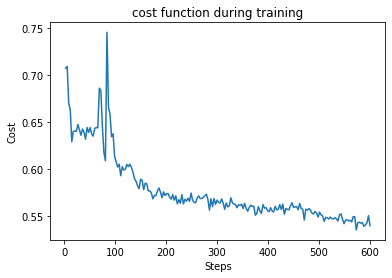

In [18]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [19]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [20]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[ 1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.]
[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1]
Test set accuracy - 0.8888888888888888


In [21]:
print(len(train_data))

60
